In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns

In [2]:
import os
import pandas as pd
dfs = []  # Create an empty list to store dataframes

# Example: Read multiple CSV files
arr_dep_dir = '../data/MBTA_Website/MBTA_Bus_Arrival_Departure_Times_2023/'
csv_files = os.listdir(arr_dep_dir)
csv_files = [os.path.join(arr_dep_dir, i) for i in csv_files][:6] 
for f in csv_files:
    df = pd.read_csv(f)
    dfs.append(df)

df = pd.concat(dfs, axis=0, ignore_index=True)
df.head()

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway
0,2023-01-01,01,Inbound,58061899.0,110,hhgat,1,Startpoint,Schedule,1900-01-01T06:05:00Z,1900-01-01T06:05:04Z,NaN,NaN
1,2023-01-01,01,Inbound,58061899.0,67,maput,2,Midpoint,Schedule,1900-01-01T06:09:00Z,1900-01-01T06:06:28Z,NaN,NaN
2,2023-01-01,01,Inbound,58061899.0,72,cntsq,3,Midpoint,Schedule,1900-01-01T06:12:00Z,1900-01-01T06:08:57Z,NaN,NaN
3,2023-01-01,01,Inbound,58061899.0,75,mit,4,Midpoint,Schedule,1900-01-01T06:15:00Z,1900-01-01T06:12:41Z,NaN,NaN
4,2023-01-01,01,Inbound,58061899.0,79,hynes,5,Midpoint,Schedule,1900-01-01T06:19:00Z,1900-01-01T06:16:35Z,NaN,NaN


In [3]:
import pandas as pd
df['scheduled'] = pd.to_datetime(df['scheduled'])
df['actual'] = pd.to_datetime(df['actual'])
df['No. of late arrivals'] = (df['actual'] > df['scheduled'])
route_ranking = df.groupby('route_id')['No. of late arrivals'].mean().reset_index()
route_ranking = route_ranking.sort_values(by='No. of late arrivals')


In [4]:
route_ranking

,route_id,No. of late arrivals
124,746_,0.174610
31,171,0.331031
148,SL2,0.335960
147,SL1,0.419509
69,351,0.419886
...,...,...
96,47,0.868806
114,65,0.870200
126,76,0.876188
88,44,0.884933


<Axes: xlabel='route_id'>

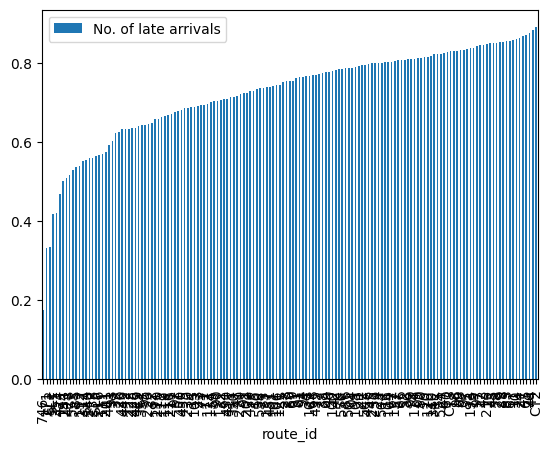

In [5]:
route_ranking.plot(kind='bar', x = 'route_id',y ='No. of late arrivals')

## Top 10 Least Late Routes

<Axes: xlabel='route_id'>

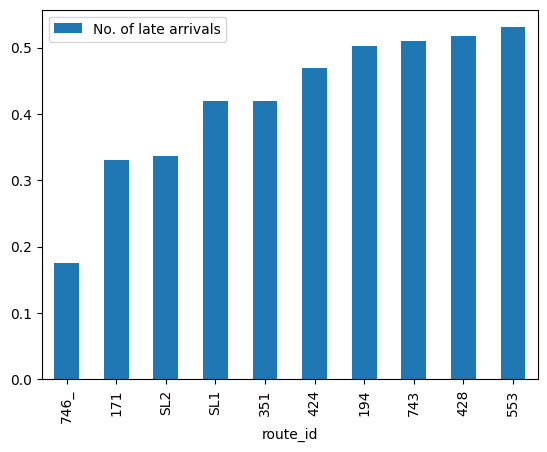

In [6]:
route_ranking[:10].plot(kind='bar', x = 'route_id',y ='No. of late arrivals')

In [7]:
stop_ids_by_route = df.groupby('route_id').agg({'stop_id': 'unique', 'time_point_order': 'unique'}).reset_index()
stop_ids_by_route.to_csv('stop_ids_by_route_ids.csv')

In [8]:
stop_ids_by_route.head()

,route_id,stop_id,time_point_order
0,01,"[110, 67, 72, 75, 79, 187, 59, 62, 64, 2, 1059...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"
1,04,"[114, 83091, 65471, 21599, 243, 30249, 113, 23...","[1, 2, 3, 4, 5, 6, 7]"
2,07,"[33, 886, 890, 892, 16535, 6564, 889, 879, 165...","[1, 2, 3, 4, 5]"
3,08,"[111, 121, 123, 10015, 64, 17863, 1799, 1804, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
4,09,"[33, 41, 45, 150, 36541, 175, 148, 151, 21, 25...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"


In [9]:
stop_data = pd.read_csv('../data/stops_locations.csv')
stop_data.head()

,object_id,stop_id,stop_name,X,Y
0,986,16535,Otis St @ Summer St,42.354243,-71.058557
1,1079,173,Saint James Ave @ Clarendon St,42.349935,-71.074649
2,1128,177,Saint James Ave @ Arlington St,42.351039,-71.070502
3,1138,178,Saint James Ave @ Dartmouth St,42.349505,-71.076639
4,1243,19031,400 Centre St - West,42.355938,-71.185299


In [10]:
import pandas as pd
import folium
import random

# Read the DataFrame with stop information
stop_data = pd.read_csv('../data/stops_locations.csv') 

# Define the list of route_ids you want to visualize
route_ids = route_ranking[:10]['route_id'].values 

boston_map = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

route_colors = {}

# Iterate through each route_id
for route_id in route_ids:
    # Generate a random color for this route
    route_color = "#{:02x}{:02x}{:02x}".format(
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)
    )
    
    route_colors[route_id] = route_color

# Iterate through each route_id and their associated stop_ids
for route_id in route_ids:
    # Get the list of stop_ids for the current route
    stop_ids = stop_ids_by_route[stop_ids_by_route['route_id'] == route_id]['stop_id'].iloc[0]

    # Create a feature group for this route
    route_group = folium.FeatureGroup(name=f'Route {route_id}')

    # Initialize a list to store sorted stop locations
    sorted_locations = []

    # Iterate through stop_ids to add markers and route lines
    for stop_id in stop_ids:
        stop_info = stop_data[stop_data['stop_id'] == stop_id]
        if not stop_info.empty:
            stop_info = stop_info.iloc[0]
            sorted_locations.append((stop_info['X'], stop_info['Y']))

    # # Sort the stop locations based on latitude (X) and longitude (Y)
    # sorted_locations.sort(key=lambda loc: (loc[0], loc[1])) # Already sorted by time_point_order

    # Add markers for sorted stops with route-specific colors
    for loc in sorted_locations:
        folium.CircleMarker(
            location=loc,
            radius=2,
            color=route_colors[route_id],
            fill=True,
            fill_color=route_colors[route_id],
            fill_opacity=1,
            popup=None
        ).add_to(route_group)

    # Add route lines based on sorted stop locations
    folium.PolyLine(
        locations=sorted_locations,
        color=route_colors[route_id]
    ).add_to(route_group)

    # Add the feature group to the map
    route_group.add_to(boston_map)

# Add layer control to toggle routes on/off
folium.LayerControl(collapsed=False).add_to(boston_map)
display(boston_map)


In [49]:
import pandas as pd
import folium
import random

# Read the DataFrame with stop information
stop_data = pd.read_csv('../data/stops_locations.csv') 

# Define the list of route_ids you want to visualize
route_ids = route_ranking[:50]['route_id'].values 

boston_map = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

route_colors = {}
heat_data = []

# Iterate through each route_id
for route_id in route_ids:
    # Generate a random color for this route
    route_color = "#{:02x}{:02x}{:02x}".format(
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)
    )
    
    route_colors[route_id] = route_color

# Iterate through each route_id and their associated stop_ids
for route_id in route_ids:
    # Get the list of stop_ids for the current route
    stop_ids = stop_ids_by_route[stop_ids_by_route['route_id'] == route_id]['stop_id'].iloc[0]

    # Initialize a list to store sorted stop locations
    sorted_locations = []

    # Iterate through stop_ids to add markers
    for stop_id in stop_ids:
        stop_info = stop_data[stop_data['stop_id'] == stop_id]
        if not stop_info.empty:
            stop_info = stop_info.iloc[0]
            sorted_locations.append((stop_info['X'], stop_info['Y']))

    # Sort the stop locations based on latitude (X) and longitude (Y)
    sorted_locations.sort(key=lambda loc: (loc[0], loc[1]))



    # Add data for the heat map
    heat_data.extend(sorted_locations)

# Draw a heat map
folium.plugins.HeatMap(heat_data).add_to(boston_map)

# Display the map
display(boston_map)

## Top 10 Most Late Routes

<Axes: xlabel='route_id'>

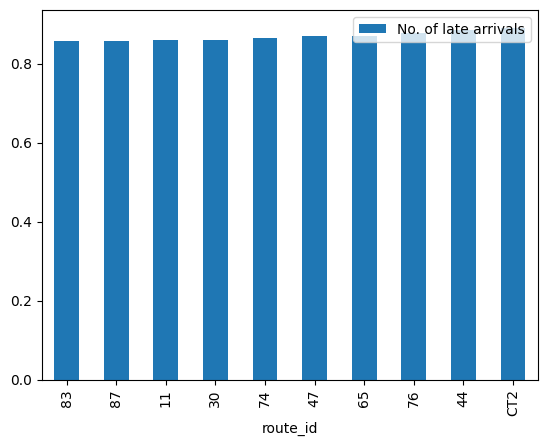

In [11]:
route_ranking[-10:].plot(kind='bar', x = 'route_id',y ='No. of late arrivals')

In [12]:
import pandas as pd
import folium
import random

# Read the DataFrame with stop information
stop_data = pd.read_csv('../data/stops_locations.csv') 

# Define the list of route_ids you want to visualize
route_ids = route_ranking[-10:]['route_id'].values 

boston_map = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

route_colors = {}

# Iterate through each route_id
for route_id in route_ids:
    # Generate a random color for this route
    route_color = "#{:02x}{:02x}{:02x}".format(
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)
    )
    
    route_colors[route_id] = route_color

# Iterate through each route_id and their associated stop_ids
for route_id in route_ids:
    # Get the list of stop_ids for the current route
    stop_ids = stop_ids_by_route[stop_ids_by_route['route_id'] == route_id]['stop_id'].iloc[0]

    # Create a feature group for this route
    route_group = folium.FeatureGroup(name=f'Route {route_id}')

    # Initialize a list to store sorted stop locations
    sorted_locations = []

    # Iterate through stop_ids to add markers and route lines
    for stop_id in stop_ids:
        stop_info = stop_data[stop_data['stop_id'] == stop_id]
        if not stop_info.empty:
            stop_info = stop_info.iloc[0]
            sorted_locations.append((stop_info['X'], stop_info['Y']))

    # Sort the stop locations based on latitude (X) and longitude (Y)
    # sorted_locations.sort(key=lambda loc: (loc[0], loc[1])) # Already sorted by time_point_order

    # Add markers for sorted stops with route-specific colors
    for loc in sorted_locations:
        folium.CircleMarker(
            location=loc,
            radius=2,
            color=route_colors[route_id],
            fill=True,
            fill_color=route_colors[route_id],
            fill_opacity=1,
            popup=None
        ).add_to(route_group)

    # Add route lines based on sorted stop locations
    folium.PolyLine(
        locations=sorted_locations,
        color=route_colors[route_id]
    ).add_to(route_group)

    # Add the feature group to the map
    route_group.add_to(boston_map)

# Add layer control to toggle routes on/off
folium.LayerControl(collapsed=False).add_to(boston_map)
display(boston_map)


In [50]:
import pandas as pd
import folium
import random

# Read the DataFrame with stop information
stop_data = pd.read_csv('../data/stops_locations.csv') 

# Define the list of route_ids you want to visualize
route_ids = route_ranking[-50:]['route_id'].values 

boston_map = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

route_colors = {}
heat_data = []

# Iterate through each route_id
for route_id in route_ids:
    # Generate a random color for this route
    route_color = "#{:02x}{:02x}{:02x}".format(
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)
    )
    
    route_colors[route_id] = route_color

# Iterate through each route_id and their associated stop_ids
for route_id in route_ids:
    # Get the list of stop_ids for the current route
    stop_ids = stop_ids_by_route[stop_ids_by_route['route_id'] == route_id]['stop_id'].iloc[0]

    # Initialize a list to store sorted stop locations
    sorted_locations = []

    # Iterate through stop_ids to add markers
    for stop_id in stop_ids:
        stop_info = stop_data[stop_data['stop_id'] == stop_id]
        if not stop_info.empty:
            stop_info = stop_info.iloc[0]
            sorted_locations.append((stop_info['X'], stop_info['Y']))

    # Sort the stop locations based on latitude (X) and longitude (Y)
    sorted_locations.sort(key=lambda loc: (loc[0], loc[1]))



    # Add data for the heat map
    heat_data.extend(sorted_locations)

# Draw a heat map
folium.plugins.HeatMap(heat_data).add_to(boston_map)

# Display the map
display(boston_map)
